In [1]:
# Load the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# 1. Data Acquisition and Loading

- Link : https://archive.ics.uci.edu/dataset/563/iranian+churn+dataset

In [3]:
# read a csv file and create a dataframe
churn_data = pd.read_csv("data/Customer Churn.csv")

In [4]:
# Display the top 5 rows of a dataframe
print("First five rows of the dataset:")
churn_data.head()

First five rows of the dataset:


,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0


In [5]:
print("Dimensions of the data frame:", churn_data.shape)

Dimensions of the data frame: (3150, 14)


In [6]:
# Check for missing values
churn_data.isnull().sum()

Call  Failure              0
Complains                  0
Subscription  Length       0
Charge  Amount             0
Seconds of Use             0
Frequency of use           0
Frequency of SMS           0
Distinct Called Numbers    0
Age Group                  0
Tariff Plan                0
Status                     0
Age                        0
Customer Value             0
Churn                      0
dtype: int64

# 2. Visualizations


### 1. Class Distribution Plot for 'Churn'

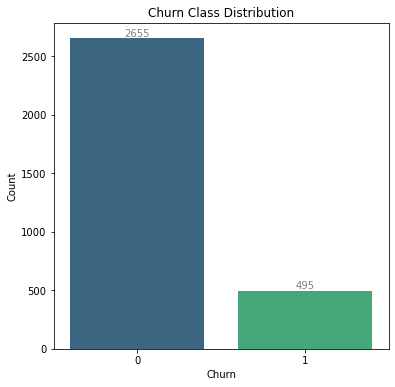

In [7]:
plt.figure(figsize=(6, 6))
ax = sns.countplot(x='Churn', data=churn_data, palette='viridis')
plt.title('Churn Class Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')

# Add count annotations on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='gray', xytext=(0, 5),
                textcoords='offset points')
plt.show()

- The graph shows a class imbalance in the dataset, with significantly more instances of class 0 (no churn) compared to class 1 (churn), indicating potential challenges for building a predictive model.

### 2. Correlation Matrix Plot to identify relationships between features and target label

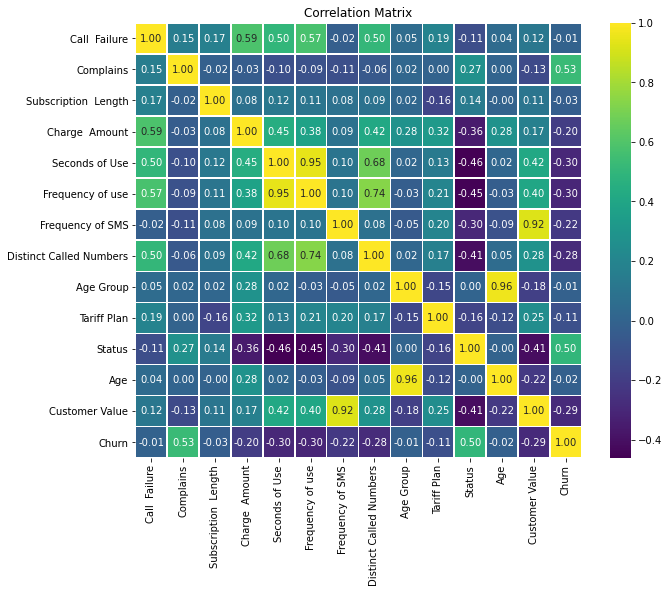

In [8]:
correlation_matrix = churn_data.corr()  # Calculating correlation for all numerical columns
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

- The heatmap shows the correlation matrix of features, revealing strong positive correlations between 'Seconds of Use' and 'Frequency of Use', and between 'Age' and 'Age Group', suggesting potential multicollinearity.  
- 'Churn' exhibits moderate negative correlation with 'Seconds of Use' and 'Frequency of Use', indicating that customers with lower usage tend to churn more.

### 3. Bar Chart to provide insights into categorical variables

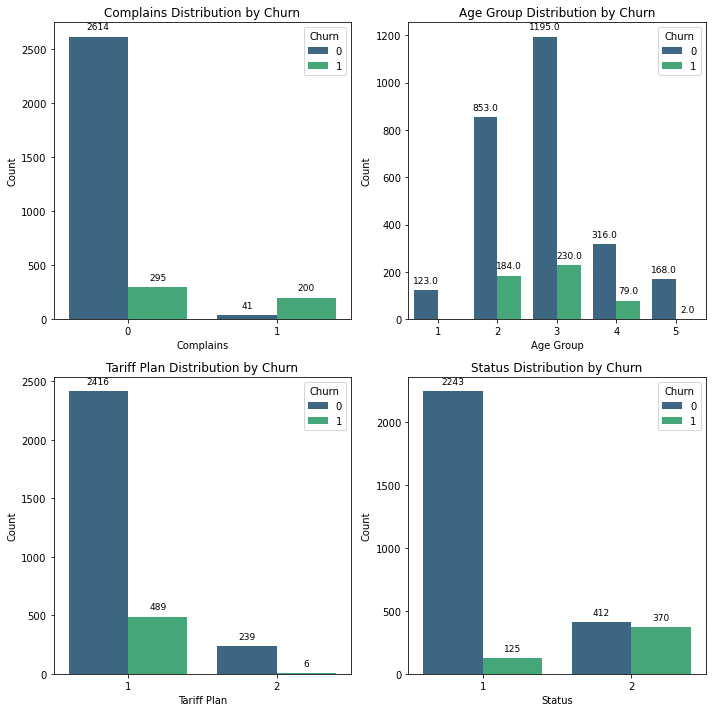

In [9]:
categorical_vars = ['Complains', 'Age Group', 'Tariff Plan', 'Status']
plt.figure(figsize=(10, 10))
for i, var in enumerate(categorical_vars, 1):
    plt.subplot(2, 2, i)
    ax = sns.countplot(x=var, hue='Churn', data=churn_data, palette='viridis')
    plt.title(f'{var} Distribution by Churn')
    plt.xlabel(var)
    plt.ylabel('Count')
    # Add count annotations on top of the bars
    for p in ax.patches:
        height = p.get_height()  # Get the height of the bar
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=9, color='black',  # Adjust fontsize as needed
                    xytext=(0, 5), textcoords='offset points')
plt.tight_layout()
plt.show()

- The charts reveal that customers with no complaints, tariff plan 1, status 1, and age group 3 are less likely to churn, while those with complaints, other tariff plans, status 2, and other age groups show higher churn rates.  
- This suggests these features are significant factors in predicting customer churn.

### 4. Histogram

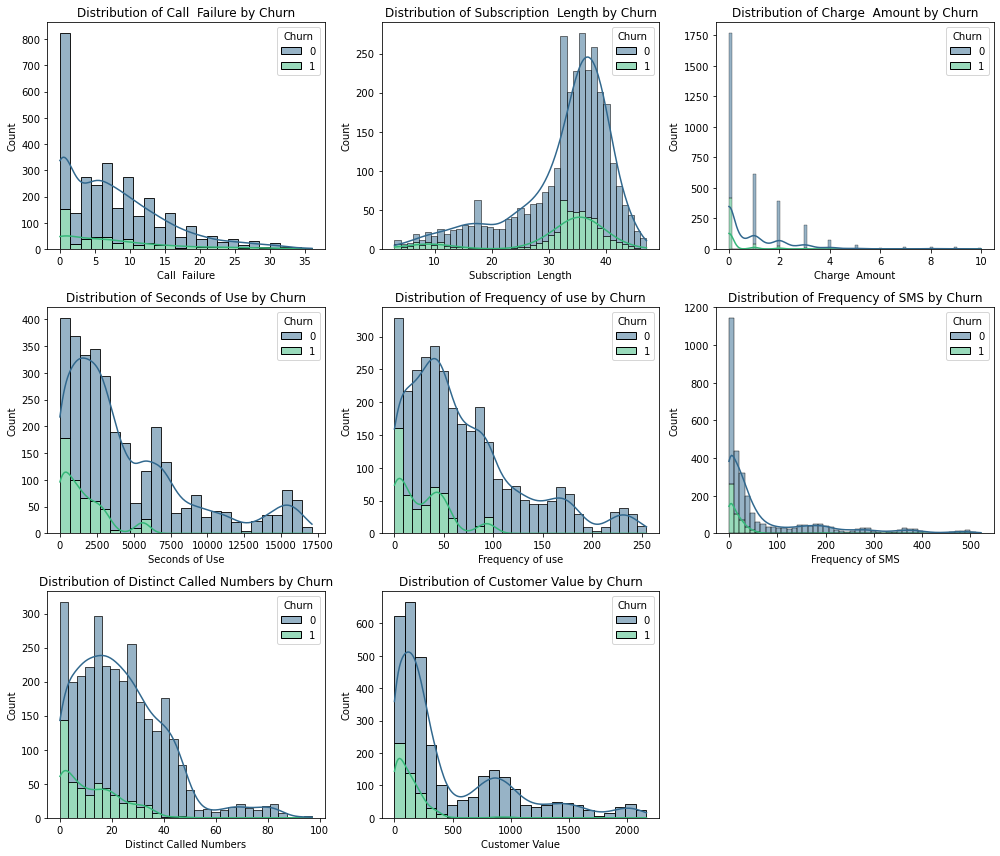

In [10]:
continuous_vars = ['Call  Failure', 'Subscription  Length', 'Charge  Amount', 'Seconds of Use', 'Frequency of use', 'Frequency of SMS', 'Distinct Called Numbers', 'Customer Value' ]
plt.figure(figsize=(14, 12))
for i, var in enumerate(continuous_vars, 1):
    plt.subplot(3, 3, i)
    sns.histplot(churn_data, x=var, hue='Churn', kde=True, multiple='stack', palette='viridis')
    plt.title(f'Distribution of {var} by Churn')
plt.tight_layout()
plt.show()

- The histograms show distinct distribution patterns between churned and non-churned customers across various features, with churned customers generally exhibiting lower usage (Seconds of Use, Frequency of Use, SMS, Distinct Calls) and shorter subscription lengths, while potentially experiencing higher call failures and charge amounts.  
- These differences suggest these features are important factors in predicting customer churn.

### 5. Feature Importance Plot

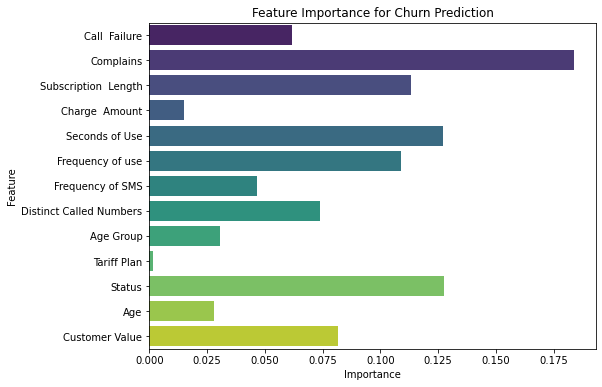

In [11]:
# Prepare the data
X = churn_data.drop(columns=['Churn'])  # Features
y = churn_data['Churn']  # Target variable
X = pd.get_dummies(X, drop_first=True)  # Convert categorical variables to dummy/indicator variables
# Train a random forest model
model = RandomForestClassifier()
model.fit(X, y)
# Plot feature importance
feature_importances = model.feature_importances_
features = X.columns
plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importances, y=features, palette='viridis')
plt.title('Feature Importance for Churn Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


- The graph highlights that 'Complaints' and 'Status' are the most important features in predicting customer churn, followed by 'Seconds of Use' and 'Subscription Length', while 'Age' and 'Charge Amount' have relatively lower importance.  
- This suggests focusing on complaint resolution and customer status management could significantly impact churn reduction.

# 3. Data Preparation

**Train-Test Split**: Divided the dataset into training (80%) and testing (20%) sets.

In [12]:
# Data Preprocessing
X = churn_data.drop(columns=["Churn"])
y = churn_data["Churn"]

In [13]:
# Splitting data
X_train_imbal, X_test_imbal, y_train_imbal, y_test_imbal = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_imbal.shape, X_test_imbal.shape, y_train_imbal.shape, y_test_imbal.shape

((2520, 13), (630, 13), (2520,), (630,))

In [14]:
# Standardizing features
scaler_imbal= StandardScaler()
X_train_imbal = scaler_imbal.fit_transform(X_train_imbal)
X_test_imbal= scaler_imbal.transform(X_test_imbal)

# 4. Model Development and Evaluation

**Addressing Class Imbalance**: Since churn is imbalanced (0: 2655, 1: 495), applied SMOTE to balance the classes.

**Scaling**: Standardized numerical features using MinMaxScaler to improve model performance.

**Model Training & Evaluation** : Designed and developed ML models

In [15]:
# Model Training and Evaluation
models_imbal= {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, 
                                            random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, 
                             eval_metric='logloss', 
                             random_state=42)
}

Decision Tree Model Evaluation - Imbalanced Data Data:

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       520
           1       0.81      0.77      0.79       110

    accuracy                           0.93       630
   macro avg       0.88      0.87      0.87       630
weighted avg       0.93      0.93      0.93       630

Accuracy: 0.9286



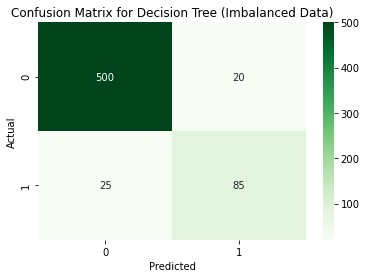

Random Forest Model Evaluation - Imbalanced Data Data:

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       520
           1       0.84      0.79      0.82       110

    accuracy                           0.94       630
   macro avg       0.90      0.88      0.89       630
weighted avg       0.94      0.94      0.94       630

Accuracy: 0.9381



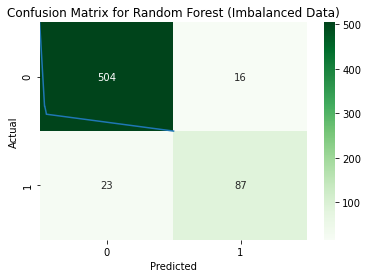

XGBoost Model Evaluation - Imbalanced Data Data:

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       520
           1       0.88      0.79      0.83       110

    accuracy                           0.94       630
   macro avg       0.92      0.88      0.90       630
weighted avg       0.94      0.94      0.94       630

Accuracy: 0.9444



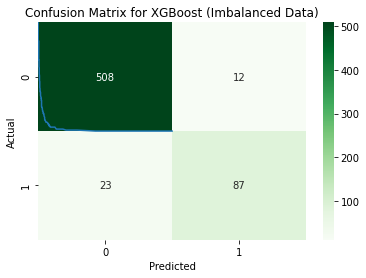

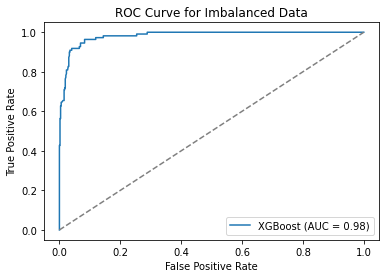

In [16]:
for name, model_imbal in models_imbal.items():
    model_imbal.fit(X_train_imbal, y_train_imbal)
    y_pred_imbal = model_imbal.predict(X_test_imbal)
    y_probs_imbal = model_imbal.predict_proba(X_test_imbal)[:, 1]  # For ROC curve
    print(f"{name} Model Evaluation - Imbalanced Data Data:")
    
    print("\nClassification Report:\n")
    print(classification_report(y_test_imbal, y_pred_imbal))
    print(f"Accuracy: {accuracy_score(y_test_imbal, y_pred_imbal):.4f}\n")

    # Confusion Matrix
    cm_imbal = confusion_matrix(y_test_imbal, y_pred_imbal)
    sns.heatmap(cm_imbal, annot=True, fmt='d', cmap='Greens')
    plt.title(f"Confusion Matrix for {name} (Imbalanced Data)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr_imbal, tpr_imbal, _ = roc_curve(y_test_imbal, y_probs_imbal)
    roc_auc_imbal = auc(fpr_imbal, tpr_imbal)
    plt.plot(fpr_imbal, tpr_imbal, label=f'{name} (AUC = {roc_auc_imbal:.2f})')

# Finalize and show ROC for oversampled models
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Imbalanced Data')
plt.legend()
plt.show()

In [17]:
# Handling imbalanced dataset using SMOTE
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [18]:
# Display the target feature distribution
y_resampled.value_counts()

1    2655
0    2655
Name: Churn, dtype: int64

In [19]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4248, 13), (1062, 13), (4248,), (1062,))

In [20]:
# Standardizing features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
# Model Training and Evaluation
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, 
                                            random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, 
                             eval_metric='logloss', 
                             random_state=42)
}

Decision Tree Model Evaluation:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       532
           1       0.95      0.96      0.95       530

    accuracy                           0.95      1062
   macro avg       0.95      0.95      0.95      1062
weighted avg       0.95      0.95      0.95      1062

Accuracy: 0.9529



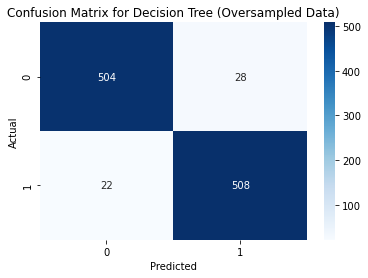

Random Forest Model Evaluation:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       532
           1       0.96      0.98      0.97       530

    accuracy                           0.97      1062
   macro avg       0.97      0.97      0.97      1062
weighted avg       0.97      0.97      0.97      1062

Accuracy: 0.9680



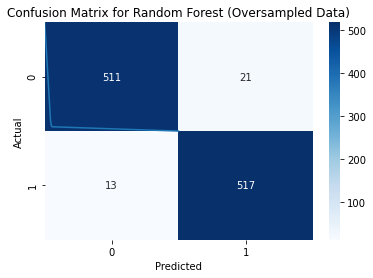

XGBoost Model Evaluation:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       532
           1       0.97      0.98      0.98       530

    accuracy                           0.98      1062
   macro avg       0.98      0.98      0.98      1062
weighted avg       0.98      0.98      0.98      1062

Accuracy: 0.9755



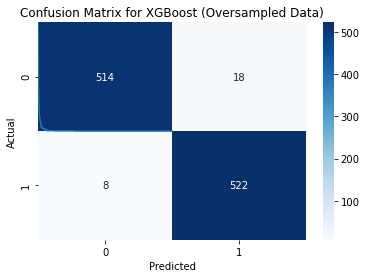

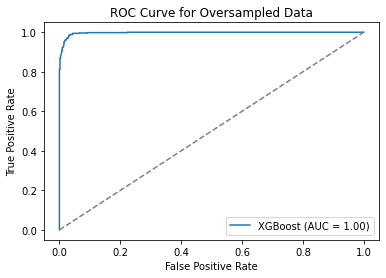

In [22]:
for name, model in models.items():
    model.fit(X_train, y_train) # Build the model(Decision Tree, Random Forest and XGBoost)
    y_pred = model.predict(X_test) # Get the prediction on test data
    y_probs = model.predict_proba(X_test)[:, 1]  # For ROC curve

    print(f"{name} Model Evaluation:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
    
        # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {name} (Oversampled Data)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    
# Finalize and show ROC for oversampled models
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Oversampled Data')
plt.legend()
plt.show()

- XGBoost demonstrated superior predictive performance and should be preferred.
- Feature importance analysis suggests that charge amount and seconds of use significantly impact churn.
- Implementing targeted retention strategies for high-risk customers based on these insights can reduce churn.
